# Notebook 1: Introducción al aprendizaje por refuerzos

Curso Aprendizaje por Refuerzos, Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

FaMAF, 2019

## Introducción

En el siguiente notebook se muestra cómo ejecutar agentes de aprendizaje por refuerzos, los cuáles son necesarios para realizar este Lab.

## Librería usada: OpenAI Gym

[OpenAI Gym](https://gym.openai.com/) (Brockman et al., 2016) es una librería de OpenAI que ofrece entornos y una interfaz estándar con la cuál probar nuestros agentes. Su objetivo es proveer benchmarks unificados para ver el desempeño de algoritmos en el entorno y así poder saber con facilidad cómo es su desempeño comparado con los demás. Parte de la siguiente sección está basada en la documentación oficial de OpenAI.

La interfaz principal de los ambientes de gym es la interfaz Env. La misma posee tres métodos principales (info. basada en la documentación oficial de Gym):


    reset(self): Reinicia el estado del entorno, a su estado inicial, devolviendo una observación de dicho estado.
    step(self, action): "Avanza" un timestep del ambiente. Devuelve: observation, reward, done, info.
    render(self): Muestra en pantalla una parte del ambiente.
    close(self): Finaliza con la instancia del agente.
    seed(self): Establece la semilla aleatoria del generador de números aleatorios del presente entorno.


Por otra parte, cada entorno posee los siguientes tres atributos principales:

    action_space: El objeto de tipo Space correspondiente al espacio de acciones válidas.
    observation_space: El objeto de tipo Space correspondiente a todos los rangos posibles de observaciones.
    reward_range: Tupla que contiene los valores mínimo y máximo de recompensa posible.

Algunas de las ejecuciones contienen videos. Para poder verlos se necesita previamente instalar la librería ffmpeg. Para hacerlo desde Linux ejecutar en consola

	sudo apt-get install ffmpeg

desde Windows descargarla desde

[https://ffmpeg.zeranoe.com/builds/]()

Ejemplo: agente CartPole

In [1]:
import gym
import time
from IPython.display import clear_output

env = gym.make('CartPole-v0')
env.reset()
for _ in range(500):
    env.render(mode='human')
    observation, reward, done, info = env.step(env.action_space.sample()) # se ejecuta una acción aleatoria
    if done:
        env.reset()
env.close()
clear_output()

Ejemplo: agente Mountain Car

In [2]:
env = gym.make('MountainCar-v0')
observation = env.reset()
for t in range(500):
    env.render(mode='human')
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done:
        print("Episode finished after {} timesteps".format(t+1))
        break
env.close()
clear_output()

## Ejemplo 1: The Cliff. 


![](images/cliffwalking.png)

donde S= starting point, G= goal

(imagen de Sutton y Barto, 2018)

Descripción del entorno:

Acciones:

* ^ - Arriba
* v - Abajo
* \> - Derecha
* < - Izquierda

Función de recompensa:

* $-1$ en todos los demás estados 
* $-100$ en el acantilado

Nota: caer en el acantilado devuelve al agente al estado inicial en un mismo episodio

Vemos los bloques básicos de nuestro agente

Primero, importamos:

In [3]:
import matplotlib.pyplot as plt
import itertools
import gym
import numpy as np
from agents.utils.plotting import plot_reward_per_episode, plot_steps_per_episode, plot_steps_per_episode_smooth, draw_value_matrix

Definimos el método de elección de acciones. En este caso el mismo utiliza la política de exploración $\epsilon$-greedy.

In [4]:
def choose_action(state):
    """
    Chooses an action according to the learning previously performed 
    using an epsilon-greedy exploration policy
    """
    #Selecciona los valores q de un estado, correspondiente a cada accion [q(s,a1),q(s,a2)...etc] en caso de no existir, la setea a 0
    q_values = [q.get((state, a), 0.0) for a in actions]
    
    #Se selecciona el(los) valor máximo para ese estado
    max_q = max(q_values)

    #EXPLORACIÓN/EXPLOTACIÓN #Se utiliza e-greedy, con epsilon% de exploración. (utilizaremos un descuendo para reducirlo con el tiempo)
    if random_state.uniform() < epsilon: #Random_state es una semilla aleatoria, nada que ver con el "estado" del agente
        
        #EXPLORACIÓN
        return random_state.choice(actions)  # a random action is selected

    
    
    #EXPLOTACIÓN
    
    
    #Cuantas acciones con maximo valor existen?
    count = q_values.count(max_q)

    # In case there're several state-action max values
    # we select a random one among them
    if count > 1:
        best = [i for i in range(len(actions)) if q_values[i] == max_q] #Almacenamos los indices de las acciones que empardaron el maximo valor de q.
        i = random_state.choice(best) #Seleccionamos aleatoriamente el índice de una de las acciones/valores maximos
    else:
        i = q_values.index(max_q) #En caso de que haya una única acción con máximo valor, se selecciona ese índice.

    return actions[i] #Devolvemos la acción correspondiente

Definimos el esqueleto del método learn, el cuál toma una transición y cambia el dict de los valores de Q de acuerdo a algún algoritmo.

In [5]:
def learn(state, action, reward, next_state, next_action):
    """
    Performs a SARSA update for a given state transition
    """
    
    # TODO - your code goes here
    
    #Valor q del estado-accion actual
    q_current = q.get((state, action), 0.0)
    
    #Valor q del estado-accion siguiente
    q_next = q.get((next_state, next_action), 0.0)
    
    #Actualizacion del valor de q del estado-accion actual
    q[state,action] = q_current + alpha*(reward+gamma*q_next - q_current)
    
    pass

Finalmente, definimos el método principal de iteraciones. 

In [6]:
def run():
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    # list that contains the amount of time-steps of the episode. It is used as a way to score the performance of
    # the agent.
    timesteps_of_episode = []
    # list that contains the amount of reward given to the agent in each episode
    reward_of_episode = []

    for i_episode in range(episodes_to_run):
        # an instance of an episode is run until it fails or until it reaches 200 time-steps

        # resets the environment, obtaining the first state observation
        state = env.reset()

        episode_reward = 0
        
        #Bandera para terminar el episodio
        done = False
        
        #La cuenta de time-step (200 límite)
        t = 0

        # Pick an action based on the current state
        action = choose_action(state)
        
        while not done:

            # Execute the action and get feedback
            next_state, reward, done, info = env.step(action) #El "done" se pone en True cuando es estado final
            
            #Al tener el siguiente estado, obtenemos la accion correspondiente a ese estado
            next_action = choose_action(next_state)
            
            #Vamos almacenando las recompesas de cada estado-acción para obtener la recompensa total por episodio (para las metricas)
            episode_reward += reward

            if not done and t < 2000:  # if the algorithm does not converge, it stops after 2000 timesteps
                
                #Se aplica el aprendizaje del agente segun el algoritmo, en este caso actualizando los q valores
                learn(state, action, reward, next_state, next_action)
                
                #El agente se sitúa en el siguiente estado
                state = next_state
                
                #El agente realiza la acción actual.
                action = next_action
            
            else:
                
                done = True  # done is ensured to be True (in the case the algorithm did not reach convergence)
                
                #Se realiza la última actualización de los q valores
                learn(state, action, reward, next_state, next_action)
                
                #Se generan las tablas para métricas
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

Definidos los métodos básicos, procedemos a instanciar a nuestro agente.

In [7]:
q = {}

# definimos sus híper-parámetros básicos

alpha = 0.5
gamma = 1
epsilon = 0.1
tau = 25

episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42) #Random_state es una semilla aleatoria, nada que ver con el estado del agente, genera confusion el nombre

Ya instanciado, ejecutamos nuestro agente

In [8]:
avg_steps_per_episode, timesteps_ep, reward_ep = run()

### Análisis de la ejecución del agente

#### Análisis de convergencia

A diferencia de lo que sucede en el aprendizaje supervisado, en el aprendizaje por refuerzos el rendimiento se evalúa por una función específica que es la función de recompensa. En la práctica, la función de recompensa puede ser externa (y provista por el entorno) o bien puede ser una función creada por diseño (a modo de dirigir el agente hacia lo que por diseño se considera mejor, en nuestro ejemplo podría ser con una recompensa de $+1$ cada vez que el agente llega al estado objetivo). Esto se conoce como *reward shaping*, y hay que tener mucho cuidado con los posibles efectos secundarios de su uso.

Como el objetivo de RL es maximizar la recompensa obtenida, es posible utilizar la información sobre la obtención de la recompensas en cada time-step o episodio para evaluar el rendimiento parcial del agente (esto depende mucho de la particularidad de la distribución de la recompensa para el problema tratado).

Para analizar la ejecución del agente, vamos a ver cómo se desempeñó el mismo en dos curvas:

* Recompensa obtenida en cada episodio: nos dirá cuánta recompensa obtuvo el agente sumando cada una de recompensas individuales de cada episodio. Con esta medida podremos tener una noción de cómo se desempeñó esquivando el acantilado y llegando lo antes posible a la meta.

* Pasos transcurridos en cada episodio: indicará cuántos pasos le ha llevado al agente la ejecución del episodio.

Se estila suavizar ambas curvas para apreciar mejor su progresión (aunque a veces suele analizarse la curva de pasos por episodio sin suavizar).

Veamos recompensa por episodio (recordar que en este entorno cada paso otorga una recompensa de $-1$ excepto al caer al acantilado, donde la recompensa es de $-100$)

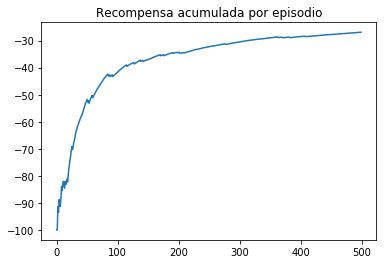

In [9]:
plot_reward_per_episode(reward_ep)

Veamos pasos por episodio

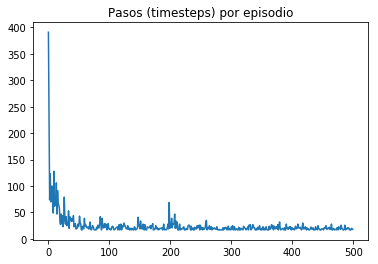

In [10]:
plot_steps_per_episode(timesteps_ep)

Suavizando...

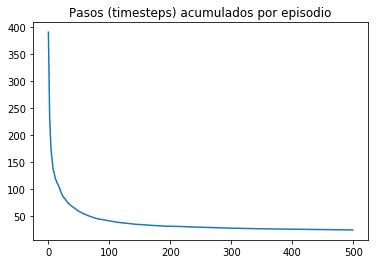

In [11]:
plot_steps_per_episode_smooth(timesteps_ep)

#### Análisis de matriz de acción-valor y política óptima

Siendo que este es un ejemplo tabular y de pocos estados / acciones, es posible realizar un análisis de convergencia desde otro punto de vista: desde el valor de la función $Q(s,a)$ para la mejor acción de cada estado, al finalizar el entrenamiento del agente, (sería la acción que el agente ejecutaría en cada estado bajo una política *greedy*). Ambos nos brindarán información sobre la convergencia alcanzada por el agente.

Tener en cuenta que este análisis se hace principalmente con fines educativos, para entornos más complejos el mismo puede no ser factible. En tales casos, un análisis alternativo podría consistir en hacer que el agente ejecute su política para la que fue entrenado, para hacer una evaluación a partir del comportamiento del mismo (esto último sería el *test de la política*, frente al *entrenamiento de la política* previo).

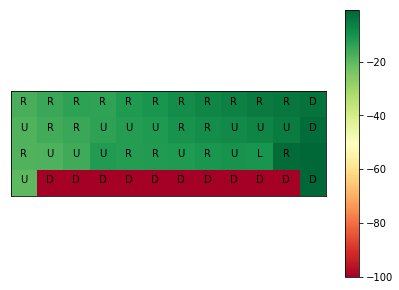


 Matriz de mejor acción-valor (en números): 

 [[ -17.23954428  -15.14316652  -13.47940719  -13.86734791  -11.50591433
   -10.42824021   -8.92910114   -7.36906975   -6.09772006   -5.02260286
    -4.246717     -3.48743802]
 [ -18.17688817  -16.29163152  -15.09887514  -13.57191616  -12.57200446
   -11.46204211  -10.28051994   -8.75636874   -8.02140089   -7.17268501
    -5.41325753   -2.24362335]
 [ -18.16818774  -17.96726471  -16.02741607  -12.12753358  -12.36502775
   -11.94064567  -11.56233996  -10.96253903   -9.96154144  -10.28531687
    -2.00258599   -1.        ]
 [ -19.72790699 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [12]:
draw_value_matrix(q)

In [13]:
env.close()

## Actividades

1. Implementar y ejecutar el algoritmo SARSA en "The Cliff".

2. Implementar y ejecutar el algoritmo Q-Learning en "The Cliff". ¿Cómo converge con respecto a SARSA? ¿A qué se debe? Comentar.

3. Ejecutando con distintos híper-parámetros, realizar una breve descripción sobre cómo afectan a la convergencia los distintos valores de $\alpha$, $\epsilon$ y $\gamma$.

4. (Opcional) Implementar política de exploración Softmax, en donde cada acción tiene una probabilidad $$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{\dot{a} \in A}e^{Q(s,\dot{a})/\tau}}$$



Para dejar el lab listo para su corrección, dejar link a repo de github con un notebook ejecutando el agente en la planilla enviada en Slack.

### 1. Implementar y ejecutar el algoritmo SARSA en "The Cliff".

In [14]:
import matplotlib.pyplot as plt
import itertools
import gym
import numpy as np
from agents.utils.plotting import plot_reward_per_episode, plot_steps_per_episode, plot_steps_per_episode_smooth, draw_value_matrix

Definimos el método de elección de acciones. En este caso el mismo utiliza la política de exploración $\epsilon$-decreasing.

In [15]:
#Agregamos epsilon para realizar el decrecimiento
def choose_action(state,epsilon):

    """
    Chooses an action according to the learning previously performed 
    using an epsilon-greedy exploration policy
    """
    #Selecciona los valores q de un estado, correspondiente a cada accion [q(s,a1),q(s,a2)...etc] en caso de no existir, la setea a 0
    q_values = [q.get((state, a), 0.0) for a in actions]
    
    #Se selecciona el(los) valor máximo para ese estado
    max_q = max(q_values)

   
    #EXPLORACIÓN/EXPLOTACIÓN #Se utiliza e-greedy, con epsilon% de exploración. (utilizaremos un descuendo para reducirlo con el tiempo)
    if random_state.uniform() < epsilon: #Random_state es una semilla aleatoria, nada que ver con el "estado" del agente
        
        #EXPLORACIÓN
        return random_state.choice(actions)  # a random action is selected

    
    
    #EXPLOTACIÓN
    
    
    #Cuantas acciones con maximo valor existen?
    count = q_values.count(max_q)

    # In case there're several state-action max values
    # we select a random one among them
    if count > 1:
        best = [i for i in range(len(actions)) if q_values[i] == max_q] #Almacenamos los indices de las acciones que empardaron el maximo valor de q.
        i = random_state.choice(best) #Seleccionamos aleatoriamente el índice de una de las acciones/valores maximos
    else:
        i = q_values.index(max_q) #En caso de que haya una única acción con máximo valor, se selecciona ese índice.

    return actions[i] #Devolvemos la acción correspondiente

##### Algoritmo SARSA

In [16]:
def learn(state, action, reward, next_state, next_action):
    """
    Performs a SARSA update for a given state transition
    """
    
    # TODO - your code goes here
    
    #Valor q del estado-accion actual
    q_current = q.get((state, action), 0.0)
    
    #Valor q del estado-accion siguiente
    q_next = q.get((next_state, next_action), 0.0)
    
    #Actualizacion del valor de q del estado-accion actual
    q[state,action] = q_current + alpha*(reward+gamma*q_next - q_current)
    
    pass

Finalmente, definimos el método principal de iteraciones. 

In [17]:
def run():
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    # list that contains the amount of time-steps of the episode. It is used as a way to score the performance of
    # the agent.
    timesteps_of_episode = []
    # list that contains the amount of reward given to the agent in each episode
    reward_of_episode = []
    
    #Definimos el epsilon como variable local, ya que se irá actualizando (decreciendo) por episodio
    epsilon=1 

    for i_episode in range(episodes_to_run):
        # an instance of an episode is run until it fails or until it reaches 200 time-steps

        # resets the environment, obtaining the first state observation
        state = env.reset()

        episode_reward = 0
        
        #Bandera para terminar el episodio
        done = False
        
        #La cuenta de time-step (200 límite)
        t = 0

        print(epsilon)
        # Pick an action based on the current state y el epsilon actualizado
        action = choose_action(state,epsilon)
        
        while not done:

            # Execute the action and get feedback
            next_state, reward, done, info = env.step(action) #El "done" se pone en True cuando es estado final
            
            #Al tener el siguiente estado, obtenemos la accion correspondiente a ese estado
            next_action = choose_action(next_state,epsilon)
            
            #Vamos almacenando las recompesas de cada estado-acción para obtener la recompensa total por episodio (para las metricas)
            episode_reward += reward

            if not done and t < 2000:  # if the algorithm does not converge, it stops after 2000 timesteps
                
                #Se aplica el aprendizaje del agente segun el algoritmo, en este caso actualizando los q valores
                learn(state, action, reward, next_state, next_action)
                
                #El agente se sitúa en el siguiente estado
                state = next_state
                
                #El agente realiza la acción actual.
                action = next_action
            
            else:
                
                done = True  # done is ensured to be True (in the case the algorithm did not reach convergence)
                
                #Se realiza la última actualización de los q valores
                learn(state, action, reward, next_state, next_action)
                
                #Se generan las tablas para métricas
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1
            
            #Actualizamos el descuento del epsilon, de exploración a explotación
            epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-descount_rate_epsilon*i_episode)
            
    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

Definidos los métodos básicos, procedemos a instanciar a nuestro agente.

In [18]:
q = {}

# definimos sus híper-parámetros básicos

#Learning rate, tasa de aprendizaje (como gradient), es un trade-off entre la experiencia vs el nuevo conocimiento.
alpha = 0.5

#Es el factor de descuento que pondera decrecientemente las futuras recompensas.
gamma = 1


#Epsilon es quien define el trade-off exploracion/explotacion con un valor de epsilon% de exploracion y de 1-epsilon% de explotacion

#Utilizaremos epsilon-decreasing, por lo cual vamos a ir decresiendo el valor de epsilon.

#Arrancamos con pura exploración (ya que las primeras acciones son necesariamente exploratorias)
#epsilon = 1


#Límite minimo de epsilon(para que no deje de explorar)
min_epsilon = 0.01

max_epsilon = 1

#Tasa de decrecimento de epsilon
descount_rate_epsilon= 0.005

#? (Para softmax?)
tau = 25

#Cantidad de episodios
episodes_to_run = 500

#ambiente
env = gym.make("CliffWalking-v0")

#Rango de acciones
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42) #Random_state es una semilla aleatoria, nada que ver con el estado del agente, genera confusion el nombre

Ya instanciado, ejecutamos nuestro agente

In [19]:
avg_steps_per_episode, timesteps_ep, reward_ep = run()

1
1.0
0.9950623544007555
0.9901493354116764
0.985260820207032
0.9803966865736877
0.9755568129080493
0.970741078213023
0.9659493620949908
0.9611815447608
0.9564375070147689
0.9517171302557069
0.947020296473949
0.9423468882484062
0.9376967887436294
0.9330698817068888
0.9284660514652673
0.9238851829227694
0.9193271615574428
0.9147918734185159
0.9102792051235491
0.9057890438555999
0.9013212773604029
0.896875793943563
0.892452482467763
0.888051232349986
0.8836719335587495
0.8793144766113556
0.8749787525711541
0.8706646530448178
0.8663720701796339
0.8621008966608072
0.8578510257087774
0.8536223510765493
0.8494147670470367
0.8452281684304199
0.8410624505615153
0.8369175092971592
0.8327932410136044
0.8286895426039287
0.8246063114754583
0.820543445547202
0.8165008432473004
0.8124784035104852
0.8084760257755536
0.8044936099828537
0.8005310565717833
0.7965882664783007
0.7926651411324482
0.7887615824558879
0.7848774928594494
0.7810127752406908
0.7771673329814701
0.7733410699455306
0.76953389047609

0.09981077375651838
0.09936284065368642
0.09891714162652515
0.09847366553253566
0.09803240128479247
0.09759333785166639
0.09715646425654882
0.09672176957757705
0.09628924294736148
0.09585887355271383
0.09543065063437678
0.09500456348675515
0.09458060145764802
0.09415875394798257
0.09373901041154904
0.09332136035473725
0.092905793336274
0.09249229896696216
0.09208086690942092


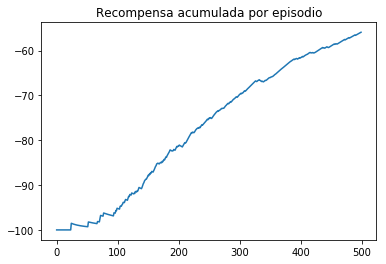

In [20]:
plot_reward_per_episode(reward_ep)

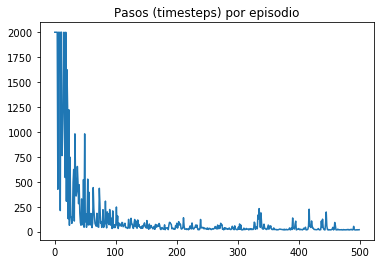

In [21]:
plot_steps_per_episode(timesteps_ep)

Suavizando...

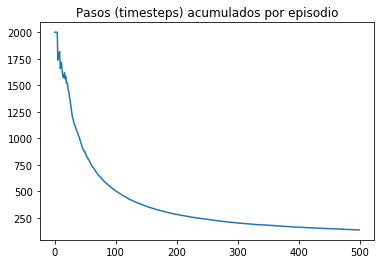

In [22]:
plot_steps_per_episode_smooth(timesteps_ep)

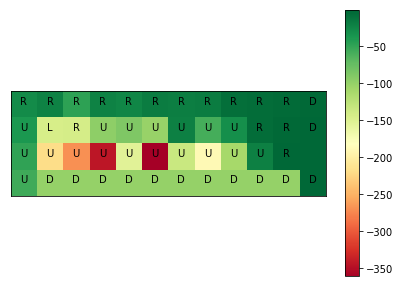


 Matriz de mejor acción-valor (en números): 

 [[ -28.82150456  -21.66149568  -45.98729657  -21.42689167  -24.13826748
   -17.35551384  -18.49112745  -16.65550324   -7.09872067   -5.59356974
    -4.46203379   -3.28575127]
 [ -38.91793962 -143.96781781 -141.94754345  -95.99241175  -86.72348776
  -101.89830455  -19.77576704  -58.44461971  -31.40358113   -5.41760113
    -3.45417181   -2.06977356]
 [ -48.31096562 -218.65170421 -268.22550476 -342.56611167 -152.81382851
  -360.69859615 -133.87624832 -187.06813304 -110.08342745  -19.62668817
    -2.00002171   -1.        ]
 [ -55.07798113 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [23]:
draw_value_matrix(q)

### 2. Implementar y ejecutar el algoritmo Q-Learning en "The Cliff". ¿Cómo converge con respecto a SARSA? ¿A qué se debe? Comentar.

In [24]:
import matplotlib.pyplot as plt
import itertools
import gym
import numpy as np
from agents.utils.plotting import plot_reward_per_episode, plot_steps_per_episode, plot_steps_per_episode_smooth, draw_value_matrix

Definimos el método de elección de acciones. En este caso el mismo utiliza la política de exploración $\epsilon$-greedy.

In [25]:
#Agregamos epsilon para realizar el decrecimiento
def choose_action(state,epsilon):

    """
    Chooses an action according to the learning previously performed 
    using an epsilon-greedy exploration policy
    """
    #Selecciona los valores q de un estado, correspondiente a cada accion [q(s,a1),q(s,a2)...etc] en caso de no existir, la setea a 0
    q_values = [q.get((state, a), 0.0) for a in actions]
    
    #Se selecciona el(los) valor máximo para ese estado
    max_q = max(q_values)

   
    #EXPLORACIÓN/EXPLOTACIÓN #Se utiliza e-greedy, con epsilon% de exploración. (utilizaremos un descuendo para reducirlo con el tiempo)
    if random_state.uniform() < epsilon: #Random_state es una semilla aleatoria, nada que ver con el "estado" del agente
        
        #EXPLORACIÓN
        return random_state.choice(actions)  # a random action is selected

    
    
    #EXPLOTACIÓN
    
    
    #Cuantas acciones con maximo valor existen?
    count = q_values.count(max_q)

    # In case there're several state-action max values
    # we select a random one among them
    if count > 1:
        best = [i for i in range(len(actions)) if q_values[i] == max_q] #Almacenamos los indices de las acciones que empardaron el maximo valor de q.
        i = random_state.choice(best) #Seleccionamos aleatoriamente el índice de una de las acciones/valores maximos
    else:
        i = q_values.index(max_q) #En caso de que haya una única acción con máximo valor, se selecciona ese índice.

    return actions[i] #Devolvemos la acción correspondiente

##### Algoritmo Q-Learning

In [26]:
def learn(state, action, reward, next_state, next_action):
    """
    Performs a SARSA update for a given state transition
    """
    
    # TODO - your code goes here
    
    #Valor q del estado-accion actual
    q_current = q.get((state, action), 0.0)
    
    #Valor q del estado-accion siguiente
    q_next = max(q.get((next_state, a), 0.0) for a in actions)
    
    #Actualizacion del valor de q del estado-accion actual
    q[state,action] = q_current + alpha*(reward+gamma*q_next - q_current)
    
    pass

Finalmente, definimos el método principal de iteraciones. 

In [27]:
def run():
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    # list that contains the amount of time-steps of the episode. It is used as a way to score the performance of
    # the agent.
    timesteps_of_episode = []
    # list that contains the amount of reward given to the agent in each episode
    reward_of_episode = []
    
    #Definimos el epsilon como variable local, ya que se irá actualizando (decreciendo) por episodio
    epsilon=1 

    for i_episode in range(episodes_to_run):
        # an instance of an episode is run until it fails or until it reaches 200 time-steps

        # resets the environment, obtaining the first state observation
        state = env.reset()

        episode_reward = 0
        
        #Bandera para terminar el episodio
        done = False
        
        #La cuenta de time-step (200 límite)
        t = 0

        print(epsilon)
        # Pick an action based on the current state y el epsilon actualizado
        action = choose_action(state,epsilon)
        
        while not done:

            # Execute the action and get feedback
            next_state, reward, done, info = env.step(action) #El "done" se pone en True cuando es estado final
            
            #Al tener el siguiente estado, obtenemos la accion correspondiente a ese estado
            next_action = choose_action(next_state,epsilon)
            
            #Vamos almacenando las recompesas de cada estado-acción para obtener la recompensa total por episodio (para las metricas)
            episode_reward += reward

            if not done and t < 2000:  # if the algorithm does not converge, it stops after 2000 timesteps
                
                #Se aplica el aprendizaje del agente segun el algoritmo, en este caso actualizando los q valores
                learn(state, action, reward, next_state, next_action)
                
                #El agente se sitúa en el siguiente estado
                state = next_state
                
                #El agente realiza la acción actual.
                action = next_action
            
            else:
                
                done = True  # done is ensured to be True (in the case the algorithm did not reach convergence)
                
                #Se realiza la última actualización de los q valores
                learn(state, action, reward, next_state, next_action)
                
                #Se generan las tablas para métricas
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1
            
            #Actualizamos el descuento del epsilon, de exploración a explotación
            epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-descount_rate_epsilon*i_episode)
            
    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

Definidos los métodos básicos, procedemos a instanciar a nuestro agente.

In [28]:
q = {}

# definimos sus híper-parámetros básicos

#Learning rate, tasa de aprendizaje (como gradient), es un trade-off entre la experiencia vs el nuevo conocimiento.
alpha = 0.5

#Es el factor de descuento que pondera decrecientemente las futuras recompensas.
gamma = 1

#Epsilon es quien define el trade-off exploracion/explotacion con un valor de epsilon% de exploracion y de 1-epsilon% de explotacion

#Utilizaremos epsilon-decreasing, por lo cual vamos a ir decresiendo el valor de epsilon.

#Arrancamos con pura exploración (ya que las primeras acciones son necesariamente exploratorias)
#epsilon = 1


#Límite minimo de epsilon(para que no deje de explorar)
min_epsilon = 0.01

max_epsilon = 1

#Tasa de decrecimento de epsilon
descount_rate_epsilon= 0.005

#? (Para softmax?)
tau = 25

#Cantidad de episodios
episodes_to_run = 500

#ambiente
env = gym.make("CliffWalking-v0")

#Rango de acciones
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42) #Random_state es una semilla aleatoria, nada que ver con el estado del agente, genera confusion el nombre

Ya instanciado, ejecutamos nuestro agente

In [29]:
avg_steps_per_episode, timesteps_ep, reward_ep = run()

1
1.0
0.9950623544007555
0.9901493354116764
0.985260820207032
0.9803966865736877
0.9755568129080493
0.970741078213023
0.9659493620949908
0.9611815447608
0.9564375070147689
0.9517171302557069
0.947020296473949
0.9423468882484062
0.9376967887436294
0.9330698817068888
0.9284660514652673
0.9238851829227694
0.9193271615574428
0.9147918734185159
0.9102792051235491
0.9057890438555999
0.9013212773604029
0.896875793943563
0.892452482467763
0.888051232349986
0.8836719335587495
0.8793144766113556
0.8749787525711541
0.8706646530448178
0.8663720701796339
0.8621008966608072
0.8578510257087774
0.8536223510765493
0.8494147670470367
0.8452281684304199
0.8410624505615153
0.8369175092971592
0.8327932410136044
0.8286895426039287
0.8246063114754583
0.820543445547202
0.8165008432473004
0.8124784035104852
0.8084760257755536
0.8044936099828537
0.8005310565717833
0.7965882664783007
0.7926651411324482
0.7887615824558879
0.7848774928594494
0.7810127752406908
0.7771673329814701
0.7733410699455306
0.76953389047609

0.12191111533404535
0.12135295631774667
0.12079758113115559
0.12024497588986349
0.11969512677871053
0.11914802005144036
0.11860364203035628
0.11806197910597942
0.11752301773670837
0.11698674444848096
0.116453145834437
0.11592220855458334
0.11539391933546027
0.1148682649698099
0.11434523231624569
0.11382480829892404
0.11330697990721733
0.11279173419538895
0.1122790582822692
0.11176893935093353
0.11126136464838206
0.11075632148522088
0.11025379723534455
0.1097537793356207
0.10925625528557566
0.10876121264708244
0.1082686390440492
0.10777852216211022
0.10729084974831793
0.10680560961083654
0.10632278961863742
0.1058423777011956
0.10536436184818809
0.10488873010919365
0.10441547059339411
0.10394457146927688
0.10347602096433932
0.10300980736479438
0.10254591901527788
0.10208434431855685
0.10162507173523985
0.10116808978348833
0.10071338703872978
0.10026095213337187
0.09981077375651838
0.09936284065368642
0.09891714162652515
0.09847366553253566
0.09803240128479247
0.09759333785166639
0.09715

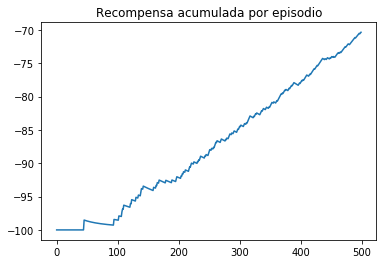

In [30]:
plot_reward_per_episode(reward_ep)

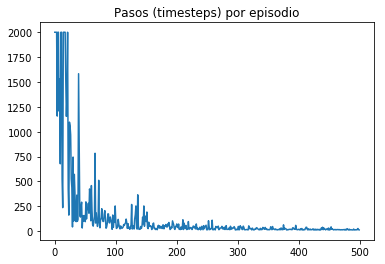

In [31]:
plot_steps_per_episode(timesteps_ep)

Suavizando...

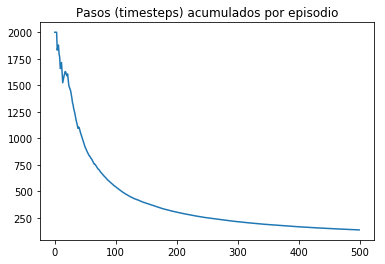

In [32]:
plot_steps_per_episode_smooth(timesteps_ep)

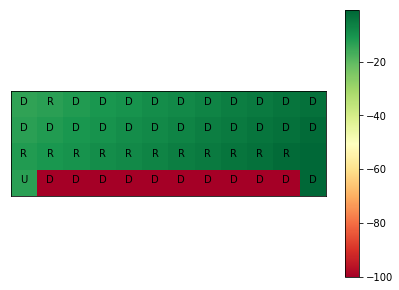


 Matriz de mejor acción-valor (en números): 

 [[ -14.  -13.  -12.  -11.  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3.]
 [ -13.  -12.  -11.  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3.   -2.]
 [ -12.  -11.  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3.   -2.   -1.]
 [ -13. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.   -1.]]


In [33]:
draw_value_matrix(q)

Con respecto a la implementación

La convergencia de **Q-Learning** respecto a **SARSA** es que en la teoría, el segundo de estos implementa un mecanismo *On-Policy*, el cual actualiza los valores Q con la acción asociada a la politica establecida, lo que lleva a este algoritmo a utilizar acciónes "conservadoras" las cuales aseguren una convergencia sin necesidad de que esta sea óptima, sino más "segura", evitando recompensas negativas.

Por el contrario **Q-Learning** se basa en una implementación *Off-Policy*, cuyo valor es independiente de la política utilizada (e.g utilizando *e-greedy*), esto nos lleva a actualizar el valor de Q con la acción que maximiza dicho valor, el cual conduce al agente a converger a una funcion de valor óptima con la consecuencia de obtener mayores recompensas-negativas, pero logrando al final del entrenamiento obtener un camino óptimo (política óptima) en relación a **SARSA**.

###### *Estas apreciaciones son respaldadas tanto por la matriz de valores -en la que SARSA se aleja de la zona de recompensas-negativas con poca exploración, mientras que Q-Learning explora hasta tal punto de obtener el camino más arriesgado pero óptimo-, como también por el gráfico de recompensas por episodios, en la que SARSA obtiene un número de recompensas acumuladas notablemente superior a Q-Learning, ya que siguió un camino mucho menos arriesgado que este último.*


### 3. Ejecutando con distintos híper-parámetros, realizar una breve descripción sobre cómo afectan a la convergencia los distintos valores de $\alpha$, $\epsilon$ y $\gamma$.

**Gamma** $\gamma$ es el *factor de descuento* y se encarga de ponderar las recompensas, en cuyo caso si su valor es *cero*, anula el "conocimiento/influencia" de las recompensas futuras, mientras que si su valor es de *uno*, brindará la misma importancia a todas las recompensas.

**Alpha** $\alpha$ se lo denomina como *"learning-rate"* o *"taza de aprendizaje"*, cumple la función de determinar "cuanta" nueva información se considerará por sobre la información ya adquirida previamente.
En tal caso si el valor de éste es *cero* entonces se mantendrá la información actual sin *"sobreescribir"* ni *"aprender"* nada, mientras que si el valor es de *uno*, se *"sobreescribirá"* toda la información previa con la nueva.

**Epsilon** $\epsilon$ está a asociado al *trade-off* exploración-explotación de la política a implementar (e.j. e-greedy, e-decreasing, e-first, etc.). 

En la cual por ejemplo en *e-greedy* utilizamos una relación de probabilidad 1-e, en la cual (caso extremo) si e=1 la acción a elegir será aleatoria (pura exploración), mientras que si e=0 entonces las acciones ya estaran determinadas (pura explotación).

En el caso de *e-first* esta relación será intercalada, una fase de pura exploración (con probabilidad uniforme entre las acciones) es seguida de una fase de pura explotación (selección de la mejor acción)

En el caso de *e-decreasing*, como su nombre lo indica, se comienza con un valor alto de epsilon, el cual va a ir disminuyendo a medida que transcurra el entrenamiento, lo que provocará que las primeras selecciones de acciones sean mayoritariamente de exploración, mientras que las ultimas serán principalmente de explotación. 


In [34]:
## Hipermarametros
gamma= 1 #0
alpha= 0 #1
#epsilon = 0 #0 No juega porque estamos usando e-decreasing con e=1 al comienzo

In [35]:
avg_steps_per_episode, timesteps_ep, reward_ep = run()

1
1.0
0.9950623544007555
0.9901493354116764
0.985260820207032
0.9803966865736877
0.9755568129080493
0.970741078213023
0.9659493620949908
0.9611815447608
0.9564375070147689
0.9517171302557069
0.947020296473949
0.9423468882484062
0.9376967887436294
0.9330698817068888
0.9284660514652673
0.9238851829227694
0.9193271615574428
0.9147918734185159
0.9102792051235491
0.9057890438555999
0.9013212773604029
0.896875793943563
0.892452482467763
0.888051232349986
0.8836719335587495
0.8793144766113556
0.8749787525711541
0.8706646530448178
0.8663720701796339
0.8621008966608072
0.8578510257087774
0.8536223510765493
0.8494147670470367
0.8452281684304199
0.8410624505615153
0.8369175092971592
0.8327932410136044
0.8286895426039287
0.8246063114754583
0.820543445547202
0.8165008432473004
0.8124784035104852
0.8084760257755536
0.8044936099828537
0.8005310565717833
0.7965882664783007
0.7926651411324482
0.7887615824558879
0.7848774928594494
0.7810127752406908
0.7771673329814701
0.7733410699455306
0.76953389047609

0.12706214447286904
0.1264782945915614
0.1258973566736851
0.125319316195762
0.12474415870674994
0.12417186982768189
0.12360243525130596
0.12303584074172813
0.12247207213405607
0.12191111533404535
0.12135295631774667
0.12079758113115559
0.12024497588986349
0.11969512677871053
0.11914802005144036
0.11860364203035628
0.11806197910597942
0.11752301773670837
0.11698674444848096
0.116453145834437
0.11592220855458334
0.11539391933546027
0.1148682649698099
0.11434523231624569
0.11382480829892404
0.11330697990721733
0.11279173419538895
0.1122790582822692
0.11176893935093353
0.11126136464838206
0.11075632148522088
0.11025379723534455
0.1097537793356207
0.10925625528557566
0.10876121264708244
0.1082686390440492
0.10777852216211022
0.10729084974831793
0.10680560961083654
0.10632278961863742
0.1058423777011956
0.10536436184818809
0.10488873010919365
0.10441547059339411
0.10394457146927688
0.10347602096433932
0.10300980736479438
0.10254591901527788
0.10208434431855685
0.10162507173523985
0.101168089

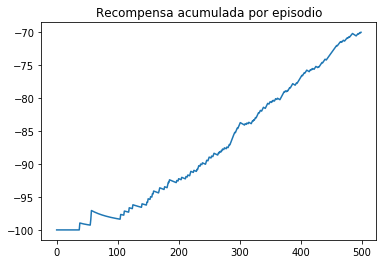

In [36]:
plot_reward_per_episode(reward_ep)

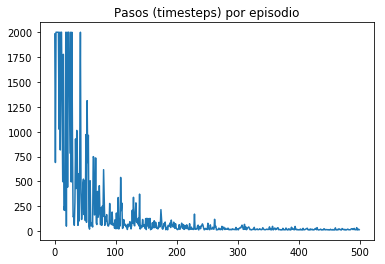

In [37]:
plot_steps_per_episode(timesteps_ep)

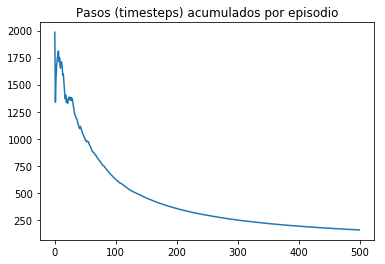

In [38]:
plot_steps_per_episode_smooth(timesteps_ep)

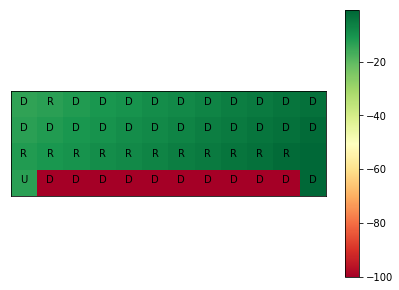


 Matriz de mejor acción-valor (en números): 

 [[ -14.  -13.  -12.  -11.  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3.]
 [ -13.  -12.  -11.  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3.   -2.]
 [ -12.  -11.  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3.   -2.   -1.]
 [ -13. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.   -1.]]


In [39]:
draw_value_matrix(q)